# K-Nearest Neighbors of AirBnB listings

Data from [insideairbnb](http://insideairbnb.com/get-the-data.html), contains listings of Boston compailed on June 10, 2020.

Objective:  
We want to aggregate similar listings and calculate their avaerage price. The output would serve as an indicator for potentially over or under priced listings.

In [1]:
# Data 
import pandas as pd
import numpy as np
# Model 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
listings = pd.read_csv("data/listings.csv")
pd.set_option('display.max_columns', None)
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20200610033559,2020-06-10,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,This is a totally separate apartment located o...,Fully separate apartment in a two apartment bu...,none,"Mostly quiet ( no loud music, no crowed sidewa...",Building is on quiet side of airport. Building...,Local subway stop ( Maverick Station on the Bl...,Guests solely occupy the 1 floor apartment wit...,We sometimes travel. Always available via: mob...,"No pets, no smoking.",NaN,NaN,https://a0.muscache.com/im/pictures/24670/b2de...,NaN,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,Massachusetts,My wife and I and grown children frequently oc...,within a day,75%,44%,t,https://a0.muscache.com/im/users/4804/profile_...,https://a0.muscache.com/im/users/4804/profile_...,East Boston,5.0,5.0,"['email', 'phone', 'reviews']",t,f,"Boston, MA, United States",East Boston,East Boston,NaN,Boston,MA,02128,Boston,"Boston, MA",US,United States,42.36413,-71.02991,t,Apartment,Entire home/apt,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",NaN,$125.00,$750.00,"$2,250.00",$0.00,$75.00,2,$0.00,28,1125,28,28,1125,1125,28.0,1125.0,4 months ago,t,0,0,7,97,2020-06-10,16,1,2015-07-10,2019-12-21,99.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""Massachusetts State"","" Massachusetts State""}",f,f,super_strict_30,f,f,1,1,0,0,0.27
1,5506,https://www.airbnb.com/rooms/5506,20200610033559,2020-06-10,**$49 Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...",**THE BEST Value in BOSTON!!*** PRIVATE GUEST ...,"Private guest room with private bath, You do n...",none,"Peacful, Architecturally interesting, historic...","Guest room is on the 3rd floor, Steps are req...","Excellent Access to all of Boston, Walk to Mus...",You get full access to the guest room with pri...,"We give guests privacy, but we are available ...",No Smoking in the Building.,NaN,NaN,https://a0.muscache.com/im/pictures/1598e8b6-5...,NaN,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, Massachusetts, United States","Relaxed, Easy going, Accommodating.",within an hour,100%,100%,t,https://a0.muscache.com/im/users/8229/profile_...,https://a0.muscache.com/i

In [3]:
listings.info(max_cols=106)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 106 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3440 non-null   int64  
 1   listing_url                                   3440 non-null   object 
 2   scrape_id                                     3440 non-null   int64  
 3   last_scraped                                  3440 non-null   object 
 4   name                                          3440 non-null   object 
 5   summary                                       3366 non-null   object 
 6   space                                         2833 non-null   object 
 7   description                                   3400 non-null   object 
 8   experiences_offered                           3440 non-null   object 
 9   neighborhood_overview                         2550 non-null   

We will select the most interesting columns with mostly non-missing values.

In [4]:
cols = ["host_response_rate", "host_acceptance_rate", "host_listings_count", "latitude",\
    "longitude", "city", "zipcode", "state", "accommodates", "room_type", "bedrooms", "bathrooms",\
    "beds", "price", "cleaning_fee", "security_deposit", "minimum_nights", "maximum_nights",\
    "number_of_reviews"]

boston_listings = listings[cols]
boston_listings.head()

,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,city,zipcode,state,accommodates,room_type,bedrooms,bathrooms,beds,price,cleaning_fee,security_deposit,minimum_nights,maximum_nights,number_of_reviews
0,75%,44%,5.0,42.36413,-71.02991,Boston,02128,MA,2,Entire home/apt,1.0,1.0,0.0,$125.00,$75.00,$0.00,28,1125,16
1,100%,100%,2.0,42.32981,-71.09559,Boston,02119,MA,2,Entire home/apt,1.0,1.0,1.0,$145.00,$60.00,$0.00,3,730,107
2,100%,100%,2.0,42.32994,-71.09351,Boston,02119,MA,4,Entire home/apt,1.0,1.0,1.0,$169.00,$80.00,$0.00,3,730,115
3,100%,82%,10.0,42.35919,-71.06265,Boston,02108,MA,2,Entire home/apt,1.0,1.0,1.0,$99.00,$250.00,"$1,000.00",91,365,25
4,100%,82%,10.0,42.35840,-71.06185,Boston,02108,MA,2,Entire home/apt,1.0,1.0,1.0,$150.00,$250.00,"$1,000.00",91,365,32


In [5]:
boston_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    2726 non-null   object 
 1   host_acceptance_rate  3159 non-null   object 
 2   host_listings_count   3436 non-null   float64
 3   latitude              3440 non-null   float64
 4   longitude             3440 non-null   float64
 5   city                  3438 non-null   object 
 6   zipcode               3424 non-null   object 
 7   state                 3440 non-null   object 
 8   accommodates          3440 non-null   int64  
 9   room_type             3440 non-null   object 
 10  bedrooms              3436 non-null   float64
 11  bathrooms             3437 non-null   float64
 12  beds                  3422 non-null   float64
 13  price                 3440 non-null   object 
 14  cleaning_fee          3046 non-null   object 
 15  security_deposit     

In [6]:
boston_listings.price = boston_listings.price\
    .str.replace("$", "").str.replace(",", "")\
    .astype("float")
boston_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    2726 non-null   object 
 1   host_acceptance_rate  3159 non-null   object 
 2   host_listings_count   3436 non-null   float64
 3   latitude              3440 non-null   float64
 4   longitude             3440 non-null   float64
 5   city                  3438 non-null   object 
 6   zipcode               3424 non-null   object 
 7   state                 3440 non-null   object 
 8   accommodates          3440 non-null   int64  
 9   room_type             3440 non-null   object 
 10  bedrooms              3436 non-null   float64
 11  bathrooms             3437 non-null   float64
 12  beds                  3422 non-null   float64
 13  price                 3440 non-null   float64
 14  cleaning_fee          3046 non-null   object 
 15  security_deposit     

## Wrangling

We will focus on ordinal data that describes the living space to train the k-nearest neighbours model.

In [7]:
drop = ["host_response_rate", "host_acceptance_rate", "host_listings_count",\
    "latitude", "longitude", "city", "zipcode", "state", "room_type"]
train_df = boston_listings.drop(drop, axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       3440 non-null   int64  
 1   bedrooms           3436 non-null   float64
 2   bathrooms          3437 non-null   float64
 3   beds               3422 non-null   float64
 4   price              3440 non-null   float64
 5   cleaning_fee       3046 non-null   object 
 6   security_deposit   2624 non-null   object 
 7   minimum_nights     3440 non-null   int64  
 8   maximum_nights     3440 non-null   int64  
 9   number_of_reviews  3440 non-null   int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 268.9+ KB


## Missing Values

In [8]:
n_records = train_df.shape[0]
print("Missing 'cleaning_fee':", round(100 * train_df.cleaning_fee.isnull().sum() / n_records, 2), "%")
print("Missing 'security_deposit':", round(100 * train_df.security_deposit.isnull().sum() / n_records, 2), "%")

Missing 'cleaning_fee': 11.45 %
Missing 'security_deposit': 23.72 %


In [9]:
train_df[train_df.cleaning_fee.isnull()].head()

,accommodates,bedrooms,bathrooms,beds,price,cleaning_fee,security_deposit,minimum_nights,maximum_nights,number_of_reviews
7,1,1.0,1.0,0.0,50.0,NaN,NaN,91,730,0
12,2,1.0,1.5,1.0,95.0,NaN,NaN,28,180,76
18,2,1.0,1.0,1.0,140.0,NaN,NaN,2,730,54
19,2,0.0,1.0,1.0,175.0,NaN,NaN,5,60,41
31,1,1.0,1.5,1.0,80.0,NaN,NaN,1,1125,30


In [10]:
train_df.cleaning_fee.value_counts()[0:10]

$100.00    331
$0.00      210
$50.00     166
$40.00     149
$30.00     123
$25.00     123
$45.00     121
$35.00     108
$75.00     106
$150.00    102
Name: cleaning_fee, dtype: int64

In [11]:
train_df.security_deposit.value_counts()[0:10]

$0.00        1110
$500.00       363
$100.00       254
$300.00       220
$200.00       183
$150.00       117
$1,000.00      95
$250.00        80
$400.00        48
$350.00        28
Name: security_deposit, dtype: int64

The percent missing values are quite substantial and there seems to be no way of inferring the data. Since values of 0 are present, it is not clear to what missing values correspond to. We will therefore excluded these two columns from the analysis;

In [12]:
drop = ["security_deposit", "cleaning_fee"]
train_df.drop(drop, axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       3440 non-null   int64  
 1   bedrooms           3436 non-null   float64
 2   bathrooms          3437 non-null   float64
 3   beds               3422 non-null   float64
 4   price              3440 non-null   float64
 5   minimum_nights     3440 non-null   int64  
 6   maximum_nights     3440 non-null   int64  
 7   number_of_reviews  3440 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 215.1 KB


For the reminder, we will drop records containing missing values.

In [13]:
train_df.dropna(axis=0, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3417 entries, 0 to 3439
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       3417 non-null   int64  
 1   bedrooms           3417 non-null   float64
 2   bathrooms          3417 non-null   float64
 3   beds               3417 non-null   float64
 4   price              3417 non-null   float64
 5   minimum_nights     3417 non-null   int64  
 6   maximum_nights     3417 non-null   int64  
 7   number_of_reviews  3417 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 240.3 KB


In [14]:
train_df.describe()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
count,3417.000000,3417.000000,3417.000000,3417.000000,3417.000000,3417.000000,3417.000000,3417.000000
mean,3.283289,1.302605,1.283436,1.779924,182.224466,32.564530,823.631548,41.037752
std,2.295486,0.956475,0.540308,1.470286,430.053869,44.056323,474.992814,69.560123
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,79.000000,2.000000,365.000000,1.000000
50%,2.000000,1.000000,1.000000,1.000000,130.000000,9.000000,1125.000000,11.000000
75%,4.000000,2.000000,1.500000,2.000000,199.000000,91.000000,1125.000000,48.000000
max,29.000000,13.000000,6.000000,22.000000,10000.000000,1000.000000,9999.000000,615.000000


Variances differ quite substantially for the futures. This may bias the model towards those features with larger values. We will Z-normalize all features.

In [15]:
# Z-normalize
normalized_train = (train_df - train_df.mean())/train_df.std()
# Reassign price
normalized_train["price"] = train_df.price
normalized_train.describe()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
count,3.417000e+03,3.417000e+03,3.417000e+03,3.417000e+03,3417.000000,3.417000e+03,3.417000e+03,3417.000000
mean,-6.550218e-17,6.238303e-17,7.485964e-17,1.871491e-17,182.224466,-6.654190e-17,-7.485964e-17,0.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,430.053869,1.000000e+00,1.000000e+00,1.000000
min,-9.946868e-01,-1.361881e+00,-2.375378e+00,-1.210597e+00,0.000000,-7.164586e-01,-1.731882e+00,-0.589961
25%,-5.590492e-01,-3.163749e-01,-5.245818e-01,-5.304574e-01,79.000000,-6.937604e-01,-9.655547e-01,-0.575585
50%,-5.590492e-01,-3.163749e-01,-5.245818e-01,-5.304574e-01,130.000000,-5.348728e-01,6.344695e-01,-0.431824
75%,3.122261e-01,7.291310e-01,4.008162e-01,1.496825e-01,199.000000,1.326381e+00,6.344695e-01,0.100090
max,1.120317e+01,1.222970e+01,8.729398e+00,1.375248e+01,10000.000000,2.195906e+01,1.931686e+01,8.251312


In [16]:
normalized_train.columns

Index(['accommodates', 'bedrooms', 'bathrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'number_of_reviews'],
      dtype='object')

## Cross validation

In [143]:
# Data
X = normalized_train[['accommodates', 'bedrooms', 'bathrooms', 'beds',\
       'minimum_nights', 'maximum_nights', 'number_of_reviews']]
y = normalized_train[['price']]

In [146]:
normalized_train[['accommodates', 'bedrooms', 'bathrooms', 'beds',\
       'minimum_nights', 'maximum_nights', 'number_of_reviews', 'price']].corr(method='spearman')

,accommodates,bedrooms,bathrooms,beds,minimum_nights,maximum_nights,number_of_reviews,price
accommodates,1.000000,0.636963,0.252105,0.778854,-0.123611,0.044219,0.089691,0.640064
bedrooms,0.636963,1.000000,0.426298,0.691242,-0.006665,-0.030276,0.007060,0.390008
bathrooms,0.252105,0.426298,1.000000,0.336092,-0.005317,0.020494,-0.066838,0.111071
beds,0.778854,0.691242,0.336092,1.000000,-0.064054,0.038967,0.057571,0.478605
minimum_nights,-0.123611,-0.006665,-0.005317,-0.064054,1.000000,0.269596,-0.355317,-0.070653
maximum_nights,0.044219,-0.030276,0.020494,0.038967,0.269596,1.000000,-0.315305,0.067815
number_of_reviews,0.089691,0.007060,-0.066838,0.057571,-0.355317,-0.315305,1.000000,-0.084237
price,0.640064,0.390008,0.111071,0.478605,-0.070653,0.067815,-0.084237,1.000000


Since linearity is not required for k-nearest neighbor models, we test correlations with the spearman method. The last three features don't appear to correlate well with price. It could be possible that there are correlations but the the relationship takes on a strange form. We will deleate the `minimum_nights` and `maximum_nights` features, since logically there should be no conncetion to price. We will keep `number_of_reviews` for now.

In [148]:
X.drop(['minimum_nights', 'maximum_nights'], axis=1, inplace=True)
X.columns

Index(['accommodates', 'bedrooms', 'bathrooms', 'beds', 'number_of_reviews'], dtype='object')

In [165]:
def optimize_split(k, features, target, start_split=2, end_split=20, plot=True):
    """Returns list of lists. First index contains lists of average RMSE terms and the 
    second index contains lists of corrsponding standard deviations.
    
    Args:
    k - 
    features -
    target -
    start_split - 
    end_split -
    plot -

    Return:
    """
    avg_rmses = []
    std_rmses = []
    # Cross-val iteration 
    for fold in range(start_split, end_split + 1):
        try:
            fold_split = KFold(fold, shuffle=True, random_state=42)
        except ValueError:
            print("Cross validation requires at least 2 splits...")
        knn = KNeighborsRegressor(k)
        rmse_array = cross_val_score(knn, features, target,\
            scoring='neg_root_mean_squared_error', cv=fold_split)
        avg_rmses.append(np.abs(rmse_array.mean()))
        std_rmses.append(rmse_array.std())
    
    # Plots
    if plot == True:
        x = list(range(2, end_split + 1))
        x_ticks = range(2, end_split + 1, 2)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
        ax[0].set_xticks(x_ticks)
        ax[0].plot(x, avg_rmses)
        ax[0].set_title('Average RMSE vs. corss-validation fold')
        ax[0].set_ylabel('Average RMSE')
        ax[0].set_xlabel('Cross-validation splits')
        ax[1].set_xticks(x_ticks)
        ax[1].plot(x, std_rmses)
        ax[1].set_title('RMSE standard deviation vs. corss-validation fold')
        ax[1].set_ylabel('RMSE standard deviation')
        ax[1].set_xlabel('Cross-validation splits')

    # Return score
    return ([avg_rmses, std_rmses])

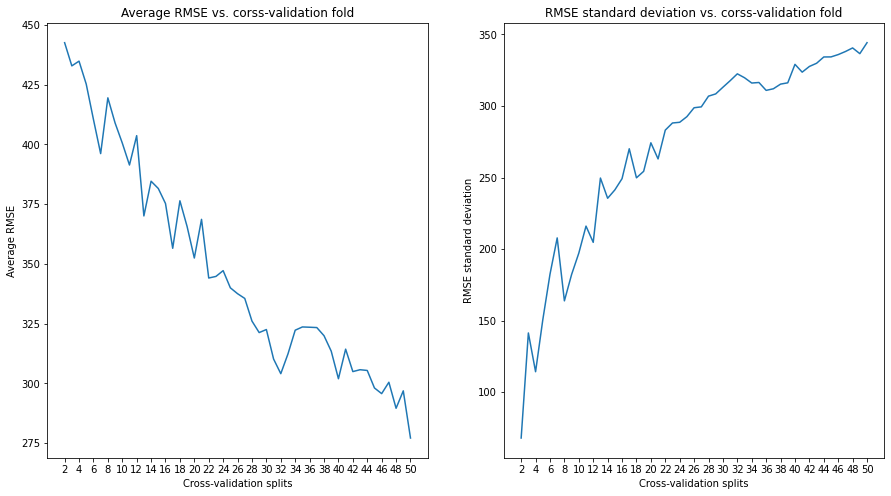

In [153]:
scores = optimize_split(k=5, end_split=50, features=X, target=y)

While the average RMSE goes continuesly down, the standard devidation, unfortunetly increases. It seems like the best combination of error and standard deviation is likely between 2 and 20. We will next optimize the hyperparameter k of the model in addition to cross-validation.

In [171]:
def optimize(n_trials, features, target, start_split, end_split, plot=False):
    """Returns list of lists. The first index contains a list of mean squared errors and 
    the second index contains a list with corresponding standard deviations. Each list pair
    is generated by varying k values from 1 to n_trials. Elements within the lists are generated
    by varying cross-validation splits from start_split to end_split.
    
    Args:
    n_trials - number of k values to test
    features - data frame containing model features
    target - series of the target
    start_split - minimum number of cross-validation splits to test for
    end_split - maximumum number of cross-validation splits to test for
    plot - if True plots the results
    
    Return:
    List of lists containing average RMSEs and their corresponding standard deviations.
    Each list index within the two outer lists (avg_rmses and std_rmses) corresponds to k as follows: index = k - 1;
    indices within the lists correspond to cross-validation splits (index = number of splits - 2).

    Example: index 5 corresponds to trials with k = 6. The Element at index 4 within the list
    at index 5 corresponds to a trial with 6 cross-validation splits. This format is the same
    for both the avg_rmses and the std_rmses lists.
    """
    avg_rmses = []
    std_rmses = []                                  
    for k in range(1, n_trials + 1):
        scores = optimize_split(k, X, y, start_split=start_split, end_split=end_split, plot = plot)
        avg_rmses.append(scores[0])
        std_rmses.append(scores[1])
    return [avg_rmses, std_rmses]

In [172]:
rmses, rmse_stds = optimize(20, X, y, 2, 10)

In [173]:
def return_best(metric_results):
    top_performers = []
    for k, metrics in enumerate(metric_results, start=1):
        min_metric = min(metrics)
        split = metrics.index(min_metric) + 2
        # Smallest mse with corresponding k and number of splits
        top_performers.append((min_metric, k, split))
    return top_performers

In [174]:
top_rmses = return_best(rmses)
top_rmse_stds = return_best(rmse_stds)

In [175]:
print("Tuples: (Average RMSE, k, splits)")
top_rmses

Tuples: (Average RMSE, k, splits)


[(370.8974070208781, 1, 7),
 (385.65773774359394, 2, 9),
 (377.86001431891464, 3, 10),
 (396.4185691858192, 4, 6),
 (396.12891150686534, 5, 7),
 (394.6475310712424, 6, 10),
 (389.23805162297475, 7, 7),
 (385.2355214729486, 8, 7),
 (381.23960316160765, 9, 7),
 (377.54183052003884, 10, 7),
 (376.65041196341724, 11, 7),
 (374.15690687354174, 12, 7),
 (374.8096626553541, 13, 7),
 (373.4501099822522, 14, 6),
 (371.680055120949, 15, 7),
 (369.30858839064905, 16, 10),
 (365.84535818979776, 17, 7),
 (367.42522809617054, 18, 10),
 (369.1660474595008, 19, 10),
 (368.6849899537961, 20, 7)]

In [176]:
print("Tuples: (RMSE standard deviation, k, splits)")
top_rmse_stds

Tuples: (RMSE standard deviation, k, splits)


[(133.66036730636483, 1, 4),
 (5.48037942385298, 2, 2),
 (44.45428184659963, 3, 2),
 (57.87929827499309, 4, 2),
 (67.91765038744649, 5, 2),
 (71.4726683128595, 6, 2),
 (70.77073268988266, 7, 2),
 (70.28698523331892, 8, 2),
 (73.3361413883525, 9, 2),
 (75.35692120168952, 10, 2),
 (77.78637789945705, 11, 2),
 (78.74741471511678, 12, 2),
 (69.26256068686624, 13, 2),
 (71.92593774884674, 14, 2),
 (73.44329003027886, 15, 2),
 (73.47902890918101, 16, 2),
 (74.38975292136436, 17, 2),
 (76.45466152482066, 18, 2),
 (75.96080673232811, 19, 2),
 (76.34483238323827, 20, 2)]

Minimum average RMSE values are well above 300 and as such quite high given that the median price is only $133. This may suggest that KNN is not the best model fit for the data.